In [1]:
!pip install numpy==1.26.0 pmdarima yfinance arch scikit-learn statsmodels

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import yfinance as yf

from arch import arch_model
from pmdarima.model_selection import train_test_split
from scipy.stats import chi2, jarque_bera
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA

In [3]:
ticker=input("Enter the ticker: ")
ticker=ticker.upper()
# ticker="AAPL"
spy=yf.Ticker(ticker)
history=spy.history(period="max")
df=pd.DataFrame(history,columns=["Close"])
df.head()

,Close
Date,
1980-12-12 00:00:00-05:00,0.098597
1980-12-15 00:00:00-05:00,0.093453
1980-12-16 00:00:00-05:00,0.086594
1980-12-17 00:00:00-05:00,0.088737
1980-12-18 00:00:00-05:00,0.091309


In [4]:
df['Return'] = np.pad(np.diff(np.log(df['Close'])) * 100, (1, 0), 'constant', constant_values=np.nan)

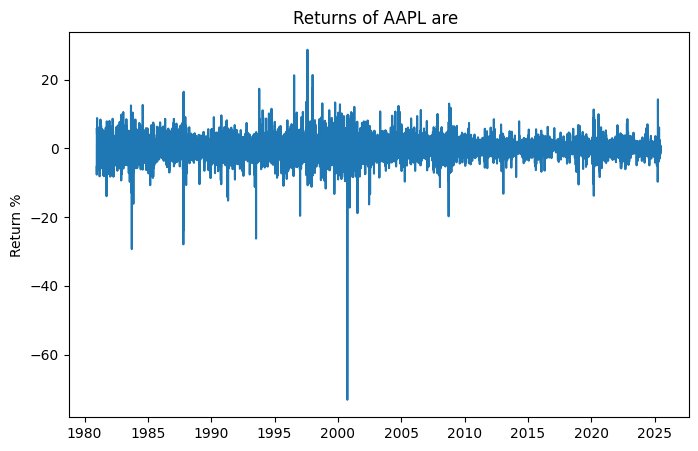

In [5]:
#EDA
plt.figure(figsize=(8,5))
plt.plot(df['Return'])
plt.ylabel("Return %")
plt.title(f'Returns of {ticker} are ');

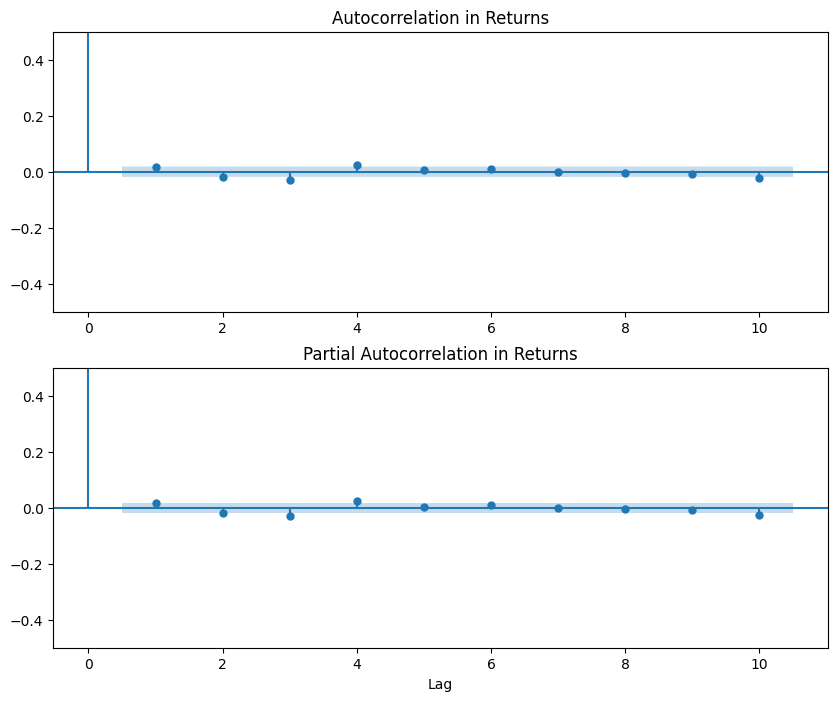

In [6]:
# Plot ACF and PACF
diff_ts = df['Return'].iloc[1:]


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(diff_ts, ax=ax1, lags=10)
ax1.set_ylim(-0.5, .5)
ax1.set_title("Autocorrelation in Returns")
plot_pacf(diff_ts, ax=ax2, lags=10)
ax2.set_ylim(-0.5, .5)
ax2.set_xlabel("Lag")
ax2.set_title("Partial Autocorrelation in Returns")

plt.show()

THE PACF ANAD ACF DONT GIVE US ANYTHING MUCH ABOVE , SO WE USE ABSOLUTE RETURENS INSTEAD TO DIMINISH THE EFFECT OF OUTLIERS


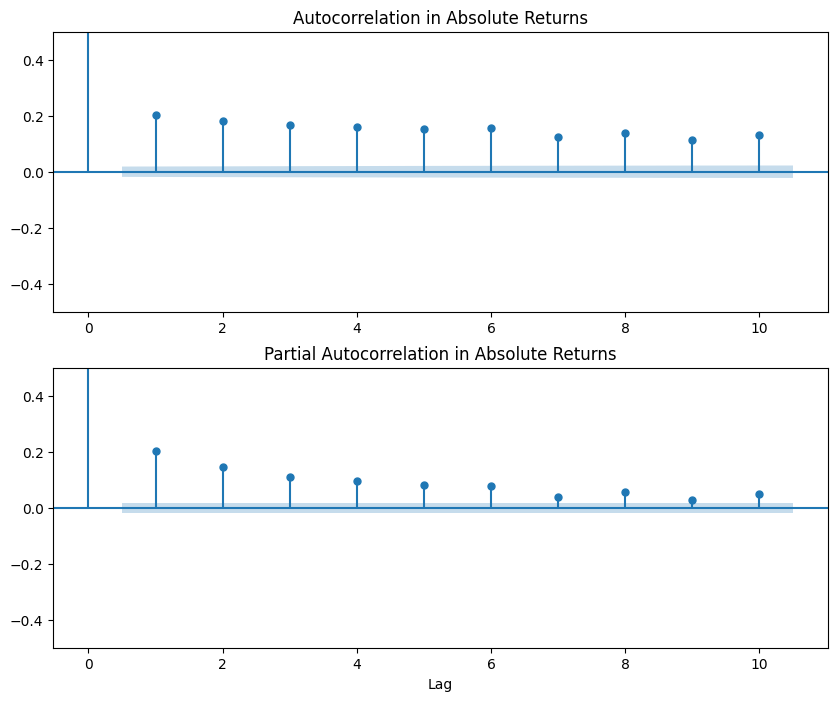

In [7]:
# Plot ACF and PACF of absolute returns
abs_returns = diff_ts.abs()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(abs_returns, ax=ax1, lags=10)
ax1.set_ylim(-.5, .5)
ax1.set_title("Autocorrelation in Absolute Returns")
plot_pacf(abs_returns, ax=ax2, lags=10)
ax2.set_ylim(-.5, .5)
ax2.set_title("Partial Autocorrelation in Absolute Returns")
ax2.set_xlabel("Lag")

plt.show();

BY THE PACF AND TEH ACF GRAPHS , WE CAN SEE THAT WE CAN CHOOSE THE VALUES FOR GARCH(P,Q) ANYTHING UNDER 6,WHERE THE DIP COMES


MC-LEOD LI TEST:

NULL HYPOTHESIS:THERE ARE NO ARCH EFFECTS PRESENT

ALTERNATIVE HYPOTHESIS:THERE ARE ARCH EFFECTS

In [8]:
def mcleod_li_test(x, k):
    """
    Calculates the McLeod-Li test statistic for a time series with k lags.
    Returns the test statistic and its p-value.
    """
    n = len(x)
    x_sq = x ** 2
    x_sum = np.sum(x_sq)
    x_lag_sum = np.sum(x_sq[:-k])
    test_stat = n * (n + 2) * x_lag_sum / (x_sum ** 2)
    df = k
    p_value = 1 - chi2.cdf(test_stat, df)
    return test_stat, p_value

In [9]:
test_stat, p_value = mcleod_li_test(abs_returns, 50)
print("McLeod-Li test statistic: ", test_stat)
print("p-value: ", p_value)

McLeod-Li test statistic:  1405.7553136154652
p-value:  0.0


In [10]:
y_train, y_test = train_test_split(abs_returns, train_size= 0.8)

garch_mod = arch_model(y_train, mean = "Zero",  vol='Garch', p=1, q=1, rescale=False)
res_garch = garch_mod.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 64743.44073334234
Iteration:      2,   Func. Count:     14,   Neg. LLF: 21788.08446032826
Iteration:      3,   Func. Count:     19,   Neg. LLF: 21807.64357541797
Iteration:      4,   Func. Count:     24,   Neg. LLF: 21712.69717248786
Iteration:      5,   Func. Count:     28,   Neg. LLF: 22032.841246150943
Iteration:      6,   Func. Count:     34,   Neg. LLF: 22253.94470888775
Iteration:      7,   Func. Count:     41,   Neg. LLF: 21711.90125064798
Iteration:      8,   Func. Count:     46,   Neg. LLF: 21711.52061913607
Iteration:      9,   Func. Count:     50,   Neg. LLF: 21711.52053662709
Iteration:     10,   Func. Count:     53,   Neg. LLF: 21711.52053663288
Optimization terminated successfully    (Exit mode 0)
            Current function value: 21711.52053662709
            Iterations: 10
            Function evaluations: 53
            Gradient evaluations: 10


In [11]:
print(res_garch.summary())#got the parameters for the model

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -21711.5
Distribution:                  Normal   AIC:                           43429.0
Method:            Maximum Likelihood   BIC:                           43450.3
                                        No. Observations:                 8975
Date:                Fri, Jun 20 2025   Df Residuals:                     8975
Time:                        09:08:24   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0887  5.459e-02      1.624      0.104 [-1.83

In [12]:
vol_ = res_garch.forecast(horizon = y_test.shape[0], reindex=True)

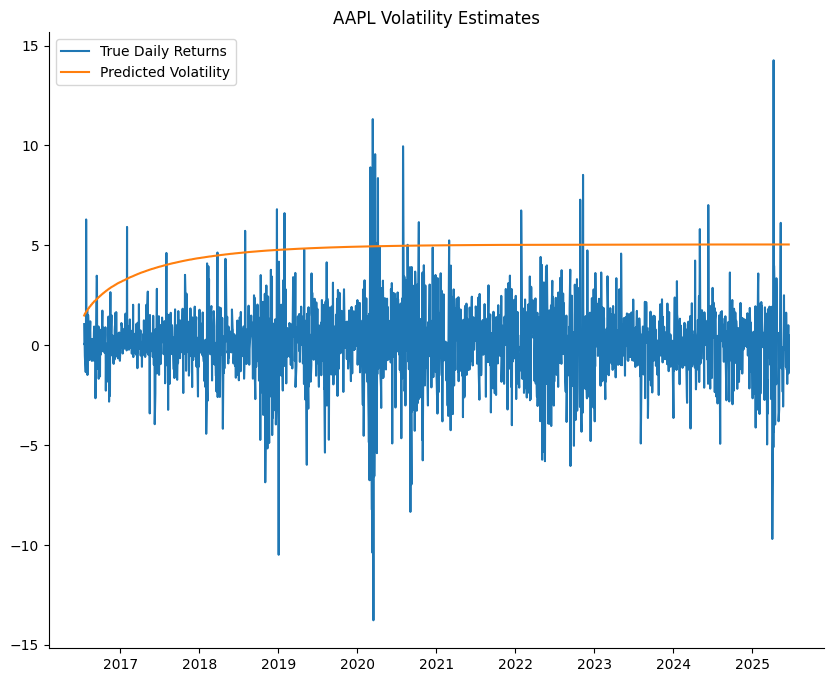

In [13]:
fig,ax = plt.subplots(figsize=(10,8))
ax.spines[['top','right']].set_visible(False)
plt.plot(diff_ts[-y_test.shape[0]:])
plt.plot(y_test.index, np.sqrt(vol_.variance.values[-1,:]))
plt.title(f"{ticker} Volatility Estimates")
plt.legend(['True Daily Returns', 'Predicted Volatility'])
predicted_volatility=plt.show()
predicted_volatility

ONE STEP AHEAD PREDICTIONS(ROLLING VOLATILITY PREDICTIONS)


In [14]:
rolling_preds = []

for i in range(y_test.shape[0]):
    train = abs_returns[:-(y_test.shape[0]-i)]
    model = arch_model(train, p=1, q=1, rescale = False)
    model_fit = model.fit(disp='off')
    # One step ahead predictor
    pred = model_fit.forecast(horizon=1, reindex=True)
    rolling_preds.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_preds = pd.Series(rolling_preds, index=y_test.index)

Text(0.5, 1.0, 'AAPL Rolling Volatility Prediction')

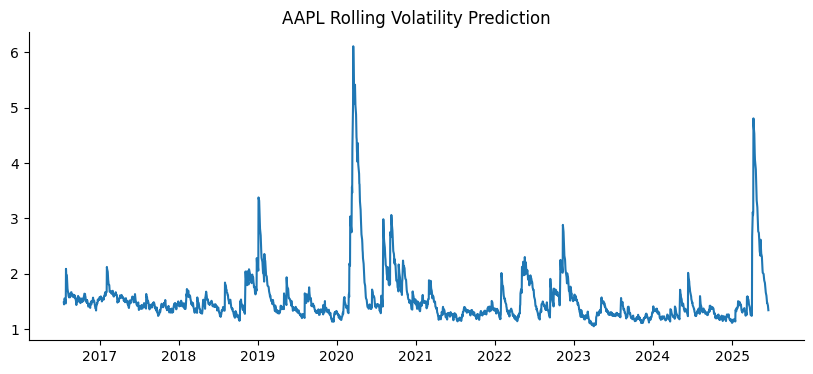

In [15]:
fig,ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_preds)
plt.title(f'{ticker} Rolling Volatility Prediction')

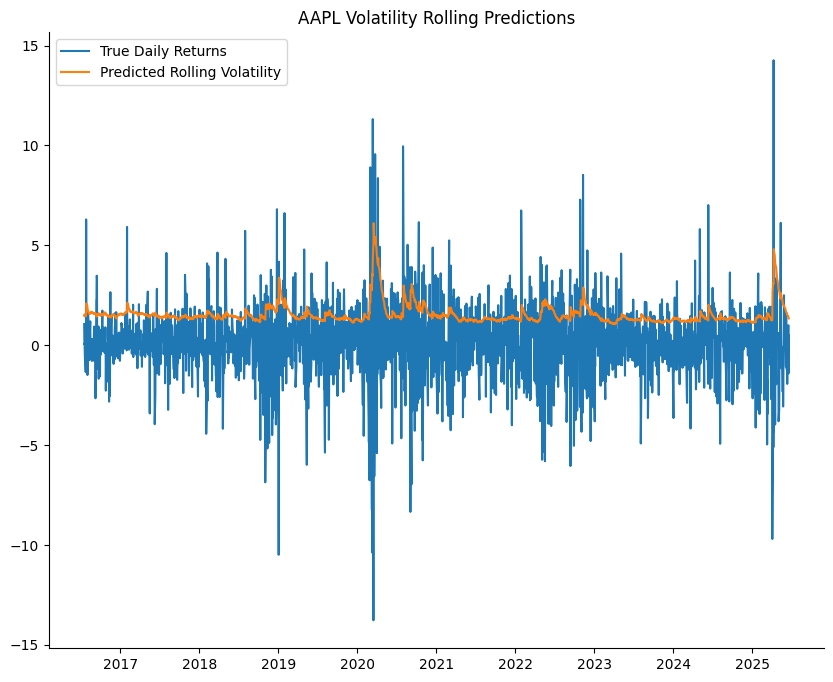

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.spines[['top','right']].set_visible(False)
ax.plot(diff_ts[-y_test.shape[0]:])
ax.plot(y_test.index,rolling_preds)
ax.set_title(f"{ticker} Volatility Rolling Predictions")
ax.legend(['True Daily Returns', 'Predicted Rolling Volatility'])
predicted_rolling_volatility=plt.show()
predicted_rolling_volatility

SENSTIVITY ANALYSIS OF THE MODEL PARAMETERS


In [17]:
pip install SALib arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 9.3 MB/s eta 0:00:00


In [18]:
from SALib.sample import saltelli
from SALib.sample import sobol as sobol_sample
from SALib.analyze import sobol
import numpy as np
import SALib

In [21]:
returns=np.log(df['Close']).diff().dropna()
returns=returns*100
returns

,Close
Date,
1980-12-15 00:00:00-05:00,-5.358050
1980-12-16 00:00:00-05:00,-7.623074
1980-12-17 00:00:00-05:00,2.444891
1980-12-18 00:00:00-05:00,2.857999
1980-12-19 00:00:00-05:00,5.923921
...,...
2025-06-12 00:00:00-04:00,0.211065
2025-06-13 00:00:00-04:00,-1.390140
2025-06-16 00:00:00-04:00,0.997806


In [33]:
problem = {
    'num_vars': 2,
    'names': ['p', 'q'],
    'bounds': [[1, 3], [1, 3]]
}

param_values = sobol_sample.sample(problem, 256)

Y = []
valid_params = []

for params in param_values:
    try:
        p = int(round(params[0]))
        q = int(round(params[1]))

        if p == 0 and q == 0:
            raise ValueError("Invalid (p,q) pair")

        model = arch_model(returns, vol='Garch', p=p, q=q, rescale=False)
        model_fit = model.fit(disp='off')
        Y.append(model_fit.aic)
        valid_params.append([p, q])

    except Exception as e:
        Y.append(np.nan)

Y = np.array(Y)
valid_params = np.array(valid_params)
Y_clean = Y[~np.isnan(Y)]

if len(Y_clean) > 32:
    print("Valid samples:", len(Y_clean))
    Si = sobol.analyze(problem, Y_clean, print_to_console=True)
    print("S1:", Si["S1"])
    print("S2:", Si["S2"])
    print("ST:", Si["ST"])
else:
    print("Not enough valid samples for analysis")

Valid samples: 1536
       ST   ST_conf
p  0.0064  0.001166
q  0.9936  0.122666
       S1   S1_conf
p  0.0064  0.012924
q  0.9936  0.156909
                  S2   S2_conf
[p, q]  2.220446e-16  0.025882
S1: [0.00639993 0.99360007]
S2: [[           nan 2.22044605e-16]
 [           nan            nan]]
ST: [0.00639993 0.99360007]


/usr/local/lib/python3.11/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
